<a href="https://colab.research.google.com/github/abhishakvarshney/Hackathon---eClerx/blob/master/Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
def download_data():
    !wget 'https://storage.googleapis.com/kaggle-data-sets/4133%2F8841%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1595929231&Signature=M2UzMApcy0Epe55p0OUB9uwn%2FQo0bWS09xzwITl0ctga0%2F7i%2FqAR%2BZcSOXvv%2F0EjECpRdu5%2FWiN89I9F25sg8u4bqQaC29bXUmxFoopThJscoFq5SinQzOSEIvLWNup2cEU94%2F%2BENpzDCvOYIJ2tE9yWv97HsGLf9qJFNqbsMsolIwfJZmqzXhqY%2FRmsPgjJ%2F3eG0AjF1HyNKIwRmyN3INMAhZbovEEKCSlTjmHg1L%2Bx8YuofBZXmLIOCYDDkPEv2jqP%2FTI6%2FPUQIznSvBZTRxR3e2LMyduHwSViUGUfLf59z0VvVcQaYDvGXFzJR%2F21h6PL%2BM3cO401dP6VuCG7kg%3D%3D' -O "data.zip"
    !unzip -o "data.zip"
    !rm -rf "data.zip"
download_data()

--2020-07-26 06:02:18--  https://storage.googleapis.com/kaggle-data-sets/4133%2F8841%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1595929231&Signature=M2UzMApcy0Epe55p0OUB9uwn%2FQo0bWS09xzwITl0ctga0%2F7i%2FqAR%2BZcSOXvv%2F0EjECpRdu5%2FWiN89I9F25sg8u4bqQaC29bXUmxFoopThJscoFq5SinQzOSEIvLWNup2cEU94%2F%2BENpzDCvOYIJ2tE9yWv97HsGLf9qJFNqbsMsolIwfJZmqzXhqY%2FRmsPgjJ%2F3eG0AjF1HyNKIwRmyN3INMAhZbovEEKCSlTjmHg1L%2Bx8YuofBZXmLIOCYDDkPEv2jqP%2FTI6%2FPUQIznSvBZTRxR3e2LMyduHwSViUGUfLf59z0VvVcQaYDvGXFzJR%2F21h6PL%2BM3cO401dP6VuCG7kg%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 176772673 (169M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 168.58M   217MB/s    in 0.8s    

2020-07-2

In [2]:
!pip install scattertext spacy_cld spacymoji empath

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


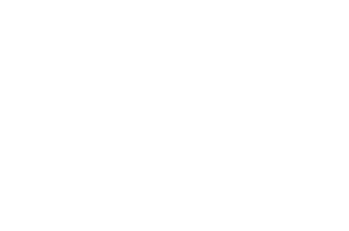

In [3]:
# library imports
import re
import numpy as np
import pandas as pd
import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import seaborn as sns
width = 0.75
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.axis('off')
from nltk.corpus import stopwords
from textblob import TextBlob
import nltk
import scattertext as st
import spacy
import spacy_cld

from IPython.display import IFrame
from IPython.core.display import display, HTML
from collections import Counter
from datetime import datetime
from tqdm.notebook import tqdm as tqdm  # cool progress bars
tqdm().pandas()  # Enable tracking of progress in dataframe `apply` calls

In [4]:
# 8192 - large enough for demonstration, larger values make network training slower
MAX_VOCAB_SIZE = 2**13
# seq2seq generally relies on fixed length message vectors - longer messages provide more info
# but result in slower training and larger networks
MAX_MESSAGE_LEN = 30  
# Embedding size for words - gives a trade off between expressivity of words and network size
EMBEDDING_SIZE = 100
# Embedding size for whole messages, same trade off as word embeddings
CONTEXT_SIZE = 100
# Larger batch sizes generally reach the average response faster, but small batch sizes are
# required for the model to learn nuanced responses.  Also, GPU memory limits max batch size.
BATCH_SIZE = 4
# Helps regularize network and prevent overfitting.
DROPOUT = 0.2
# High learning rate helps model reach average response faster, but can make it hard to 
# converge on nuanced responses
LEARNING_RATE=0.005

# Tokens needed for seq2seq
UNK = 0  # words that aren't found in the vocab
PAD = 1  # after message has finished, this fills all remaining vector positions
START = 2  # provided to the model at position 0 for every response predicted

# Implementaiton detail for allowing this to be run in Kaggle's notebook hardware
SUB_BATCH_SIZE = 1000

In [5]:
tweets = pd.read_csv('twcs/twcs.csv',encoding='utf-8')
print(tweets.shape)
tweets.head(5)

(2811774, 7)


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [6]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811774 entries, 0 to 2811773
Data columns (total 7 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tweet_id                 int64  
 1   author_id                object 
 2   inbound                  bool   
 3   created_at               object 
 4   text                     object 
 5   response_tweet_id        object 
 6   in_response_to_tweet_id  float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 131.4+ MB


In [7]:
def missingData(data):
    '''
    @author steno
    Check the missing data in the features.
    This function returns  dataframe with the missing values.
    '''
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    md = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    md = md[md["Percent"] > 0]
    sns.set(style = 'darkgrid')
    plt.figure(figsize = (8, 4))
    plt.xticks(rotation='90')
    sns.barplot(md.index, md["Percent"],color="g",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    return md

,Total,Percent
response_tweet_id,1040629,37.009696
in_response_to_tweet_id,794335,28.250315


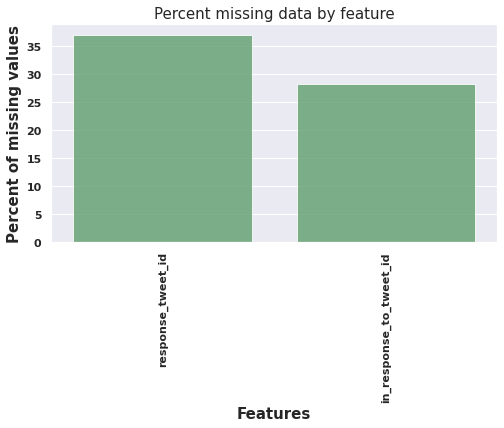

In [8]:
missingData(tweets)

In [9]:
first_inbound = tweets[pd.isnull(tweets.in_response_to_tweet_id) & tweets.inbound]

QnR = pd.merge(first_inbound, tweets, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id')

# Filter to only outbound replies (from companies)
QnR = QnR[QnR.inbound_y ^ True]
print(f'Data shape: {QnR.shape}')
QnR.head(3)

Data shape: (794299, 14)


,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
0,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0
1,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,9,sprintcare,False,Tue Oct 31 21:46:14 +0000 2017,@115712 I would love the chance to review the ...,NaN,8.0
2,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,10,sprintcare,False,Tue Oct 31 21:45:59 +0000 2017,@115712 Hello! We never like our customers to ...,NaN,8.0


,Total,Percent
in_response_to_tweet_id_x,794299,100.000000
response_tweet_id_y,530528,66.791976


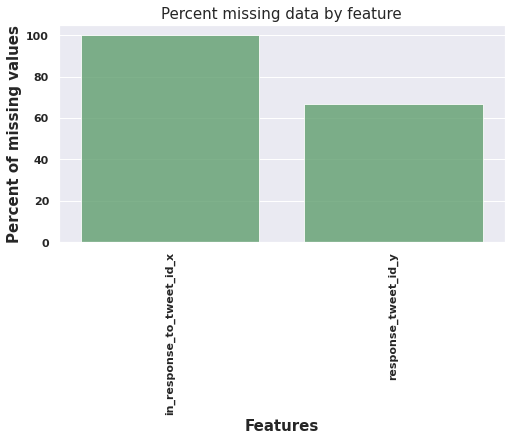

In [10]:
missingData(QnR)

In [11]:
# removing anonymized screen names 
def sn_replace(match):
    _sn = match.group(2).lower()
    if not _sn.isnumeric():
        # This is a company screen name
        return match.group(1) + match.group(2)
    return ''

sn_re = re.compile('(\W@|^@)([a-zA-Z0-9_]+)')
print("Removing anonymized screen names in X...")
QnR["text_x"] = QnR.text_x.progress_apply(lambda txt: sn_re.sub(sn_replace, txt))
print("Removing anonymized screen names in Y...")
QnR["text_y"] = QnR.text_y.progress_apply(lambda txt: sn_re.sub(sn_replace, txt))

Removing anonymized screen names in X...



Removing anonymized screen names in Y...


In [12]:
#making sure the dataframe contains only the needed columns
QnR = QnR[["tweet_id_x", "author_id_x","created_at_x","text_x","author_id_y","created_at_y","text_y"]]
QnR.head(5)

,tweet_id_x,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y
0,8,115712,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:24 +0000 2017,"Can you please send us a private message, so ..."
1,8,115712,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:14 +0000 2017,I would love the chance to review the account...
2,8,115712,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:45:59 +0000 2017,Hello! We never like our customers to feel li...
3,18,115713,Tue Oct 31 19:56:01 +0000 2017,y’all lie about your “great” connection. 5 ba...,sprintcare,Tue Oct 31 19:59:13 +0000 2017,H there! We'd definitely like to work with yo...
4,20,115715,Tue Oct 31 22:03:34 +0000 2017,"whenever I contact customer support, they tel...",sprintcare,Tue Oct 31 22:10:10 +0000 2017,Please send me a private message so that I ca...


In [13]:
QnR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 794299 entries, 0 to 875291
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tweet_id_x    794299 non-null  int64 
 1   author_id_x   794299 non-null  object
 2   created_at_x  794299 non-null  object
 3   text_x        794299 non-null  object
 4   author_id_y   794299 non-null  object
 5   created_at_y  794299 non-null  object
 6   text_y        794299 non-null  object
dtypes: int64(1), object(6)
memory usage: 48.5+ MB


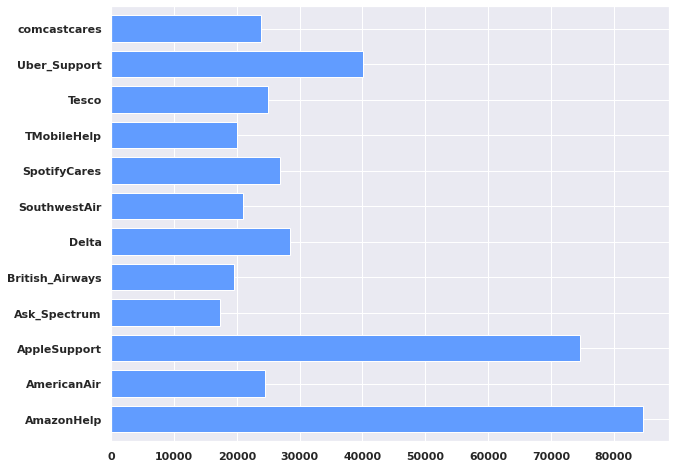

In [14]:
count = QnR.groupby("author_id_y")["text_x"].count()
c = count[count>15000].plot(kind='barh',figsize=(10, 8), color='#619CFF', zorder=2, width=width,)
c.set_ylabel('')
plt.show()

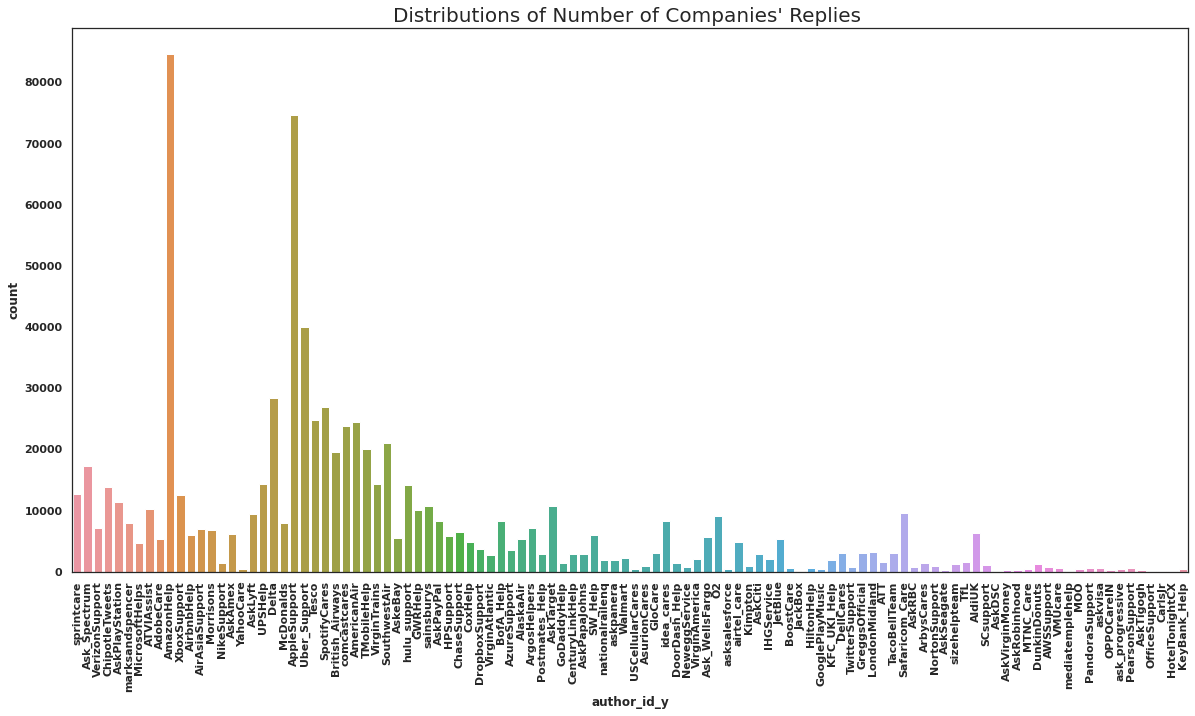

In [15]:
plt.figure(figsize=(20, 10))
sns.set_style('white')
sns.countplot(x='author_id_y', data=QnR)
plt.xticks(rotation = 90)
plt.title("Distributions of Number of Companies' Replies ", fontsize = 20)
plt.show()

In [16]:
author_grouped = QnR.groupby('author_id_y')
top_support_providers = set(author_grouped.agg('count').sort_values(['tweet_id_x'], ascending=[0]).index[:20].values)

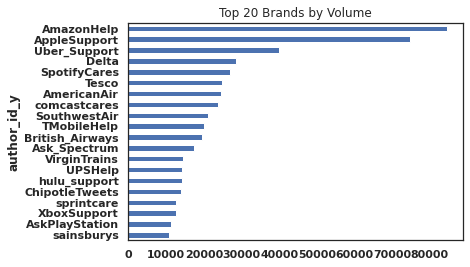

In [17]:
QnR.loc[QnR.author_id_y.isin(top_support_providers)].groupby('author_id_y').tweet_id_x.count().sort_values().plot(kind='barh', title='Top 20 Brands by Volume')

In [18]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

def sentiment_for(text: str) -> float:
    return sentiment_analyzer.polarity_scores(text)['compound']
QnR['inbound_sentiment'] = QnR.text_x.progress_apply(sentiment_for)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


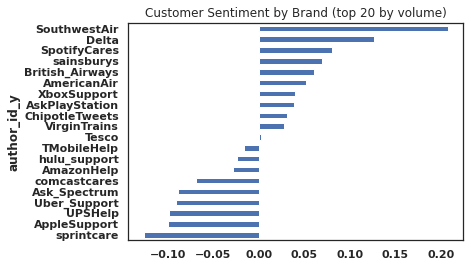

In [19]:
QnR \
    .loc[QnR.author_id_y.isin(top_support_providers)] \
    .groupby('author_id_y') \
    .inbound_sentiment.mean() \
    .sort_values() \
    .plot(kind='barh', title='Customer Sentiment by Brand (top 20 by volume)')

In [20]:
QnR['created_at_x'] = pd.to_datetime(QnR.created_at_x)

In [21]:
apple_tweets = QnR \
    .loc[QnR.author_id_y == 'AppleSupport']

Text(0, 0.5, 'Customer Sentiment')

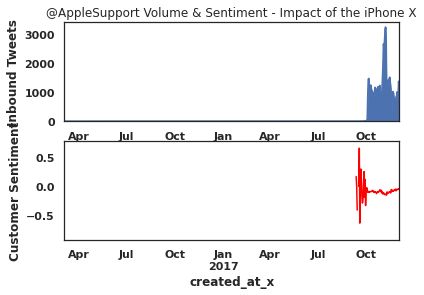

In [22]:
plt.subplot(2, 1, 1)

ax = apple_tweets \
    .groupby(pd.Grouper(key='created_at_x', freq='24h')) \
    .count() \
    .tweet_id_x.sort_index() \
    .plot(title='@AppleSupport Volume & Sentiment - Impact of the iPhone X', kind='area')
ax.set_ylabel('Inbound Tweets')
    

plt.subplot(2, 1, 2)
ax = apple_tweets \
    .groupby(pd.Grouper(key='created_at_x', freq='24h')) \
    .inbound_sentiment.mean() \
    .sort_index() \
    .plot(color='red')
ax.set_ylabel('Customer Sentiment')

In [23]:
amazonQnR = QnR[QnR["author_id_y"]=="AmazonHelp"]

In [24]:
amazonQnR.tail(10)["text_x"]

875206                   アマゾンのプライムビデオの調子が悪い\nちょいちょい再生エラーが出る
875207                                    アマゾンを騙った架空請求SMS来た
875208    10月半ばに密林で注文したピンセットが未だに届かないんだが\nいくらなんでも遅すぎだろう\n...
875239    さっきつくったクレカが届いてAmazonプライムに早速なった〜(*⌒▽⌒*)♥幸せだ〜♥はや...
875240      there should be bonus and gifts for regular ...
875241    Amazonで注文したDVDがまだ届かない･･･\n昨日まで到着予定なんだけど問い合わせする...
875242    たいへん！！Amazonでピンク動画見たら請求来た！！私の消息途絶えたらAmazonに社会か...
875270    架空請求きたよww\n\nしかとショートメールでAmazon相談係。 https://t.c...
875271    Señores de estoy confuso sobre el público dest...
875286     いきなり来たんだけど\nなんですかこれ！！？\n https://t.co/4dhaXWNqB4
Name: text_x, dtype: object

In [25]:
# amazonQnR["text_x"] = amazonQnR["text_x"].str.encode("utf-8")
# amazonQnR["text_x"] = amazonQnR["text_x"].apply(str)

In [26]:
nlp_cld = spacy.load('en',disable_pipes=["tagger","ner"])
language_detector = spacy_cld.LanguageDetector()
nlp_cld.add_pipe(language_detector)

In [27]:
doc = nlp_cld(amazonQnR.iloc[4]["text_x"])
print(doc)
print(doc._.languages)  
print(doc._.language_scores)

 also, beim Addams Family-Film in Prime sind Bild und Ton nicht wirklich synchron. Wie kommt's?
['de']
{'de': 0.98}


In [28]:
mask = []
try:
    for i,doc in tqdm(enumerate(nlp_cld.pipe(amazonQnR["text_x"], batch_size=512))):
            if 'en' not in doc._.languages or len(doc._.languages) != 1:
                mask.append(False)
            else:
                mask.append(True)
except Exception:
    print("excepted ")

In [29]:
amazonQnR = amazonQnR[mask]
# sample a random fraction to visually ensure that we have only English tweets
amazonQnR.sample(frac=0.0002)

,tweet_id_x,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,inbound_sentiment
616372,2142520,629959,2017-10-19 08:49:38+00:00,@AmazonHelp horrible service during Diwali! Di...,AmazonHelp,Thu Oct 19 09:15:29 +0000 2017,I'm sorry for that. Please fill in your detai...,-0.7177
703473,2424483,696244,2017-11-14 18:43:38+00:00,@AmazonHelp money came out my account for amaz...,AmazonHelp,Tue Nov 14 18:50:43 +0000 2017,That's odd! Let's take a look at this further...,0.3400
243086,897689,333186,2017-10-21 03:17:27+00:00,Consecutive Third failure by Amazon transporta...,AmazonHelp,Sat Oct 21 03:29:26 +0000 2017,Apologies for the trouble with the delivery o...,-0.7579
125817,481583,229468,2017-12-01 14:04:37+00:00,what is the point of asking for delivery inst...,AmazonHelp,Fri Dec 01 14:06:30 +0000 2017,I'm terribly sorry to hear how your parcel wa...,-0.7569
455760,1645160,502725,2017-11-06 01:23:58+00:00,The new amazon shipping (AMZL) is garbage! I ...,AmazonHelp,Mon Nov 06 01:36:25 +0000 2017,Yikes! We'd like our team to take a look into...,0.3147
226462,837820,319380,2017-10-13 10:10:33+00:00,Look at the MRP. Amazon you are making people ...,AmazonHelp,Fri Oct 13 10:28:32 +0000 2017,in our prices over time. I will take this as ...,-0.2960
295616,1082937,142724,2017-10-23 17:27:44+00:00,@AmazonHelp hi trying to cancel a preorder for...,AmazonHelp,Mon Oct 23 17:39:12 +0000 2017,Oh no! Which browser are you using? Have you ...,-0.1280
835988,2859761,794696,2017-11-27 22:35:31+00:00,My mother just spent over an hour on the phon...,AmazonHelp,Mon Nov 27 22:43:00 +0000 2017,I'm sorry to hear about the recent gift card ...,0.5813
704648,2428208,697187,2017-11-26 18:06:24+00:00,@AmazonHelp what kind of morons are you hirin...,AmazonHelp,Sun Nov 26 18:10:02 +0000 2017,I'm sorry for the trouble with your delivery....,-0.6275
801285,2746004,158716,2017-11-20 21:49:12+00:00,@AmazonHelp do you keep track of how many pack...,AmazonHelp,Mon Nov 20 21:51:26 +0000 2017,Do you have an order that is late? We'd like ...,0.0000


In [30]:
amazonQnR.tail(10)["text_x"]

875016    Why have you lied to me.... First you take sev...
875017            \nWhat about the ONEPLUS 5T quiz results?
875021     Order # 404-7515535-6833945 organic Gobi Berr...
875022     Order # 404-7515535-6833945 organic Gobi Berr...
875023    Hey, If a customer emails with two questions a...
875064    @AmazonHelp I sent you guys a DM regarding the...
875129    This is happening in my area w “Prime” deliver...
875176     got my #OnePlus5T at 8:45am. Thanks for fulfi...
875205     No exchange available for #OnePlus5T. I need ...
875240      there should be bonus and gifts for regular ...
Name: text_x, dtype: object

In [31]:
!python -m spacy download en_core_web_lg
!python -m spacy link en_core_web_lg en --force

     |████████████████████████████████| 827.9MB 63.4MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp36-none-any.whl size=829180944 sha256=40ce896f0383f5fb94ef54b1c72895866faafc27b7a7fa563e2c5a47efc8f138
  Stored in directory: /tmp/pip-ephem-wheel-cache-vi7l2_f3/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_lg -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [32]:
nlp = spacy.load("en",disable_pipes=["tagger"])

from spacymoji import Emoji
emoji = Emoji(nlp)
nlp.add_pipe(emoji, first=True)

In [33]:
print(nlp.pipe_names)

['emoji', 'tagger', 'parser', 'ner']


In [34]:
emojis = []
for doc in tqdm(nlp.pipe(amazonQnR["text_x"], batch_size=512)):
    if doc._.has_emoji:
        for e in doc._.emoji:
            emojis.extend(e[0])

In [35]:
eCount = Counter(emojis)
eCount.most_common(10)

[('😡', 1519),
 ('🤔', 538),
 ('🙄', 504),
 ('😭', 493),
 ('😂', 448),
 ('😠', 295),
 ('🙃', 293),
 ('🏻', 289),
 ('😒', 279),
 ('️', 278)]

In [36]:
response_emojis = []
for doc in tqdm(nlp.pipe(amazonQnR["text_y"], batch_size=512)):
    elist = []
    if doc._.has_emoji:
        for e in doc._.emoji:
            elist.append(e[0])
    response_emojis.append(elist)

In [37]:
Counter([item for sublist in response_emojis for item in sublist]).most_common(10)

[('😊', 212),
 ('😁', 201),
 ('😍', 163),
 ('❤', 96),
 ('😉', 83),
 ('😀', 44),
 ('😎', 42),
 ('📦', 42),
 ('😃', 34),
 ('🎁', 34)]

In [38]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sent_analyser = SentimentIntensityAnalyzer()
positive_text = "love this phone! its the best one I've owned over the years"
negative_text = "what sort of company makes such products? this phone hangs up all the time and is totally useless"
print("positive_text sentiment : ",sent_analyser.polarity_scores(positive_text)["compound"])
print("negative_text sentiment : ",sent_analyser.polarity_scores(negative_text)["compound"])

     |████████████████████████████████| 133kB 8.0MB/s 
positive_text sentiment :  0.8655
negative_text sentiment :  -0.4754


In [39]:
def sentiment(text):
    return (sent_analyser.polarity_scores(text)["compound"] + TextBlob(text).sentiment.polarity)/2
amazonQnR["text_x_sentiment"] = amazonQnR["text_x"].apply(sentiment)

In [40]:
response_emojis_for_positive_queries = []
response_emojis_for_negative_queries = []
for i,sentiment in enumerate(amazonQnR["text_x_sentiment"]):
    if sentiment > 0.0:
        response_emojis_for_positive_queries.extend(response_emojis[i])
    elif sentiment < 0.0:
        response_emojis_for_negative_queries.extend(response_emojis[i])

In [41]:
amazonQnR[amazonQnR["text_x_sentiment"]>0].head()

,tweet_id_x,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,inbound_sentiment,text_x_sentiment
93,621,115822,2017-10-31 22:19:34+00:00,I want my amazon payments account CLOSED. dm...,AmazonHelp,Tue Oct 31 22:28:34 +0000 2017,I am unable to affect your account via Twitte...,0.5106,0.205300
96,632,115829,2017-10-31 21:34:58+00:00,my package was ‘accidentally’ opened.. 4 item...,AmazonHelp,Tue Oct 31 22:27:00 +0000 2017,I'm sorry your order arrived in this conditio...,0.4912,0.392475
98,636,115832,2017-10-31 22:05:36+00:00,"Thanks for the style advice, look ...I think? ...",AmazonHelp,Tue Oct 31 22:26:07 +0000 2017,Alexa says both styles are working for you! M...,0.4404,0.320200
102,652,115838,2017-10-31 22:11:15+00:00,@AmazonHelp Is it possible to prevent AMZL fro...,AmazonHelp,Tue Oct 31 22:24:47 +0000 2017,Oh no! We want to hear more about your experi...,0.0258,0.012900
103,659,115839,2017-10-31 22:02:14+00:00,", it’d be nice if the book I waited 4 months f...",AmazonHelp,Tue Oct 31 22:11:00 +0000 2017,I'm sorry your book arrived this way! You can...,-0.0258,0.287100


In [42]:
Counter(response_emojis_for_positive_queries).most_common(10)

[('😁', 166),
 ('😊', 165),
 ('😍', 120),
 ('❤', 73),
 ('😉', 56),
 ('📦', 35),
 ('😎', 34),
 ('😃', 29),
 ('😀', 28),
 ('🎁', 28)]

In [43]:
Counter(response_emojis_for_negative_queries).most_common(10)


[('😊', 28),
 ('😁', 23),
 ('😉', 14),
 ('😍', 13),
 ('😀', 7),
 ('☺', 7),
 ('🎉', 6),
 ('🤔', 5),
 ('📚', 4),
 ('😅', 4)]

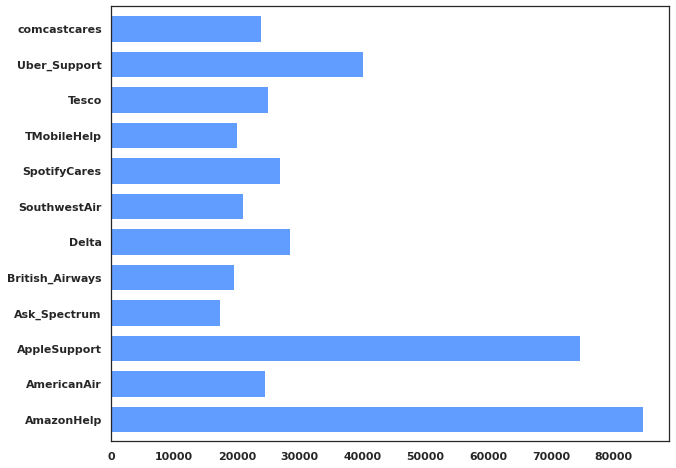

In [44]:
count = QnR.groupby("author_id_y")["text_x"].count()
c = count[count>15000].plot(kind='barh',figsize=(10, 8), color='#619CFF', zorder=2, width=width,)
c.set_ylabel('')
plt.show()

In [45]:
airlinesQnR = QnR[(QnR["author_id_y"]=="AmericanAir")|(QnR["author_id_y"]=="British_Airways")]
airlinesQnR.head(4)

,tweet_id_x,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,inbound_sentiment
147,872,115892,2017-10-31 16:08:21+00:00,Hi @British_Airways! My flight from MAN--LHR--...,British_Airways,Tue Oct 31 22:28:36 +0000 2017,caused. We're unable to offer a complimentary...,-0.2344
148,872,115892,2017-10-31 16:08:21+00:00,Hi @British_Airways! My flight from MAN--LHR--...,British_Airways,Tue Oct 31 22:26:30 +0000 2017,We're so sorry to hear your flight was cancel...,-0.2344
149,877,115893,2017-10-31 16:47:55+00:00,@British_Airways will you ever address my com...,British_Airways,Tue Oct 31 22:26:11 +0000 2017,email address and contact telephone number. W...,-0.4329
150,877,115893,2017-10-31 16:47:55+00:00,@British_Airways will you ever address my com...,British_Airways,Tue Oct 31 22:25:34 +0000 2017,We apologise for not responding sooner. We're...,-0.4329


In [46]:
import nltk
nltk.download('stopwords')
airlinesQnR["text_y"] = airlinesQnR["text_y"].str.lower()  
stop = stopwords.words('english')
big_regex = re.compile(' | '.join(stop))
airlinesQnR["text_y"].progress_apply(lambda x: big_regex.sub(" ",x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


147        caused. we're unable offer complimentary upgr...
148        we're sorry hear flight cancelled, bryce. we'...
149        email address contact telephone number. we'll...
150        apologise not responding sooner. we're follow...
151                         h sam, is correct email. ^helen
                                ...                        
875222     we're sorry any difficulties you're experienc...
875223     care. you'd like, please share record locator...
875224      looks like have pretty good view today! thanks.
875225     we're showing either these flights be diverte...
875263     was very chilly morning, simon. i’m sure grou...
Name: text_y, Length: 44117, dtype: object

In [47]:
import scattertext as st
nlp = spacy.load('en',disable_pipes=["tagger","ner"])
airlinesQnR['parsed'] = airlinesQnR.text_y.progress_apply(nlp)

In [48]:
corpus = st.CorpusFromParsedDocuments(airlinesQnR,
                             category_col='author_id_y',
                             parsed_col='parsed').build()

In [49]:
html = st.produce_scattertext_explorer(corpus,
          category='British_Airways',
          category_name='British Airways',
          not_category_name='American Airlines',
          width_in_pixels=600,
          minimum_term_frequency=10,
          term_significance = st.LogOddsRatioUninformativeDirichletPrior(),
          )

In [50]:
filename = "americanAir-vs-britishAirways.html"
open(filename, 'wb').write(html.encode('utf-8'))
IFrame(src=filename, width = 800, height=700)

In [51]:
feat_builder = st.FeatsFromOnlyEmpath()
empath_corpus = st.CorpusFromParsedDocuments(airlinesQnR,
                                              category_col='author_id_y',
                                              feats_from_spacy_doc=feat_builder,
                                              parsed_col='parsed').build()

In [52]:
html = st.produce_scattertext_explorer(empath_corpus,
                                        category='British_Airways',
                                        category_name='British Airways',
                                        not_category_name='American Airlines',
                                        width_in_pixels=700,
                                        metadata=airlinesQnR['author_id_y'],
                                        use_non_text_features=True,
                                        use_full_doc=True,
                                        topic_model_term_lists=feat_builder.get_top_model_term_lists())


In [53]:
filename = "empath-BA-vs-AA.html"
open(filename, 'wb').write(html.encode('utf-8'))
IFrame(src=filename, width = 900, height=700)

In [54]:
corpus = (st.CorpusFromParsedDocuments(airlinesQnR,
                             category_col='author_id_y',
                             parsed_col='parsed').build().get_stoplisted_unigram_corpus())


In [55]:
target_term = 'delay'
html = st.word_similarity_explorer(corpus,
                                   category='British_Airways',
                                   category_name='British Airways',
                                   not_category_name='American Airlines',
                                   target_term=target_term,
                                   minimum_term_frequency=5,
                                   width_in_pixels=800)


Streaming output truncated to the last 5000 lines.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.6/runpy.py:193: Use

In [56]:
file_name = 'similarity.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1000, height=700)

In [57]:
html = st.produce_projection_explorer(corpus,
                                   category='British_Airways',
                                   category_name='British Airways',
                                   not_category_name='American Airlines',
                                   width_in_pixels=800)

**Lower case**

In [58]:
def remove_uppercase(text):
    text_lowercase = ' '.join(x.lower() for x in text.split())# It will discard all uppercases
    return text_lowercase

In [59]:
QnR['text_x_clean'] = QnR['text_x'].apply(lambda x: remove_uppercase(x))
QnR['text_y_clean'] = QnR['text_y'].apply(lambda x: remove_uppercase(x))
#in modo da poter rimuovere i nomi delle compagnie
QnR['author_id_y'] = QnR['author_id_y'].apply(lambda x: remove_uppercase(x))

In [60]:
QnR.head(3)

,tweet_id_x,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,inbound_sentiment,text_x_clean,text_y_clean
0,8,115712,2017-10-31 21:45:10+00:00,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:24 +0000 2017,"Can you please send us a private message, so ...",-0.6249,@sprintcare is the worst customer service,"can you please send us a private message, so t..."
1,8,115712,2017-10-31 21:45:10+00:00,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:14 +0000 2017,I would love the chance to review the account...,-0.6249,@sprintcare is the worst customer service,i would love the chance to review the account ...
2,8,115712,2017-10-31 21:45:10+00:00,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:45:59 +0000 2017,Hello! We never like our customers to feel li...,-0.6249,@sprintcare is the worst customer service,hello! we never like our customers to feel lik...


**Remove Puntuaction**


In [61]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [62]:
def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])# It will discard all punctuations
    return text_nopunct

In [63]:
QnR['text_x_clean'] = QnR['text_x_clean'].apply(lambda x: remove_punct(x))
QnR['text_y_clean'] = QnR['text_y_clean'].apply(lambda x: remove_punct(x))
QnR.head(3)

,tweet_id_x,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,inbound_sentiment,text_x_clean,text_y_clean
0,8,115712,2017-10-31 21:45:10+00:00,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:24 +0000 2017,"Can you please send us a private message, so ...",-0.6249,sprintcare is the worst customer service,can you please send us a private message so th...
1,8,115712,2017-10-31 21:45:10+00:00,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:14 +0000 2017,I would love the chance to review the account...,-0.6249,sprintcare is the worst customer service,i would love the chance to review the account ...
2,8,115712,2017-10-31 21:45:10+00:00,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:45:59 +0000 2017,Hello! We never like our customers to feel li...,-0.6249,sprintcare is the worst customer service,hello we never like our customers to feel like...


**Removing usernames**

In [64]:
# usernames = QnR['author_id_x'].unique()
companies = QnR['author_id_y'].unique()

In [65]:
# gli username dei clienti sono numeri
QnR['text_x_clean'] = QnR['text_x_clean'].str.replace('\d+', '')
QnR['text_y_clean'] = QnR['text_y_clean'].str.replace('\d+', '')

In [66]:
QnR['text_x_clean'] = QnR['text_x_clean'].str.replace('|'.join(companies), '')
QnR['text_y_clean'] = QnR['text_y_clean'].str.replace('|'.join(companies), '')
QnR.head(3)

,tweet_id_x,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,inbound_sentiment,text_x_clean,text_y_clean
0,8,115712,2017-10-31 21:45:10+00:00,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:24 +0000 2017,"Can you please send us a private message, so ...",-0.6249,is the worst customer service,can you please send us a private message so th...
1,8,115712,2017-10-31 21:45:10+00:00,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:14 +0000 2017,I would love the chance to review the account...,-0.6249,is the worst customer service,i would love the chance to review the account ...
2,8,115712,2017-10-31 21:45:10+00:00,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:45:59 +0000 2017,Hello! We never like our customers to feel li...,-0.6249,is the worst customer service,hello we never like our customers to feel like...


**Checking Most Common Words**

In [67]:
freqX = pd.Series(' '.join(QnR['text_x_clean']).split()).value_counts()[:10]
freqY = pd.Series(' '.join(QnR['text_y_clean']).split()).value_counts()[:10]
print('FREQ X: \n',freqX,'\nFREQ Y: \n', freqY)

FREQ X: 
 to     450708
i      402410
the    394075
my     310589
a      289701
and    250511
is     210725
for    199908
on     184316
you    172954
dtype: int64 
FREQ Y: 
 to      597009
you     562841
the     438570
your    355927
we      300934
us      281678
for     280735
can     262541
a       257072
this    245768
dtype: int64


In [68]:
#removing them
freqX = list(freqX.index)
freqY = list(freqY.index)
QnR['text_x_clean'] = QnR['text_x_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in freqX))
QnR['text_y_clean'] = QnR['text_y_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in freqY))

**Checking Most Rare Words**

In [69]:
rareX = pd.Series(' '.join(QnR['text_x_clean']).split()).value_counts()[-100:]
rareY = pd.Series(' '.join(QnR['text_y_clean']).split()).value_counts()[-100:]
print('RARE X: \n',rareX,'\nRARE Y: \n', rareY)

RARE X: 
 daffichage            1
httpstcoubblxztade    1
porkbellysoup         1
rogerrocks            1
httpstcoynrpakh       1
                     ..
httpstcojmobexkcj     1
httpstcokbachedj      1
httpstcogrkomyxt      1
httpstcohxpohit       1
dontuber              1
Length: 100, dtype: int64 
RARE Y: 
 naitasia                                                                                  1
httpstcowshdqh                                                                            1
ticketjourney                                                                             1
お支払い番号は、発行済みの場合、アカウントサービスの注文履歴から番号を確認することが可能です。詳しくはリンクのヘルプページをご参照ください。httpstcoxgrxngsx    1
diviértete                                                                                1
                                                                                         ..
ご迷惑をおかけしております。カスタマーサービスの返答がない場合には、こちらから再度お問合せください。                                        1
httpstcoedwplyig                             

In [70]:
#removing them
rareX = list(rareX.index)
rareY = list(rareY.index)
QnR['text_x_clean'] = QnR['text_x_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in rareX))
QnR['text_y_clean'] = QnR['text_y_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in rareY))

**Tokenizing**

In [71]:
import re

# Function to Tokenize words
def tokenize(text):
    tokens = re.split('\W+', text) #W+ means that either a word character (A-Za-z0-9_) or a dash (-) can go there.
    return tokens

In [72]:
QnR['text_x_tokenized'] = QnR['text_x_clean'].apply(lambda x: tokenize(x.lower())) 
QnR['text_y_tokenized'] = QnR['text_y_clean'].apply(lambda x: tokenize(x.lower()))
#We convert to lower as Python is case-sensitive.
QnR.head(3)

,tweet_id_x,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,inbound_sentiment,text_x_clean,text_y_clean,text_x_tokenized,text_y_tokenized
0,8,115712,2017-10-31 21:45:10+00:00,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:24 +0000 2017,"Can you please send us a private message, so ...",-0.6249,worst customer service,please send private message so that i gain fur...,"[worst, customer, service]","[please, send, private, message, so, that, i, ..."
1,8,115712,2017-10-31 21:45:10+00:00,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:14 +0000 2017,I would love the chance to review the account...,-0.6249,worst customer service,i would love chance review account and provide...,"[worst, customer, service]","[i, would, love, chance, review, account, and,..."
2,8,115712,2017-10-31 21:45:10+00:00,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:45:59 +0000 2017,Hello! We never like our customers to feel li...,-0.6249,worst customer service,hello never like our customers feel like they ...,"[worst, customer, service]","[hello, never, like, our, customers, feel, lik..."


**Remove StopWords**

In [73]:
import nltk

stopword = nltk.corpus.stopwords.words('english') # All English Stopwords

# Function to remove Stopwords
def remove_stopwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stopword]# To remove all stopwords
    return text

QnR['text_x_tokenized'] = QnR['text_x_tokenized'].apply(lambda x: remove_stopwords(x))
QnR['text_y_tokenized'] = QnR['text_y_tokenized'].apply(lambda x: remove_stopwords(x))
QnR.head(3)

,tweet_id_x,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,inbound_sentiment,text_x_clean,text_y_clean,text_x_tokenized,text_y_tokenized
0,8,115712,2017-10-31 21:45:10+00:00,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:24 +0000 2017,"Can you please send us a private message, so ...",-0.6249,worst customer service,please send private message so that i gain fur...,"[worst, customer, service]","[please, send, private, message, gain, details..."
1,8,115712,2017-10-31 21:45:10+00:00,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:14 +0000 2017,I would love the chance to review the account...,-0.6249,worst customer service,i would love chance review account and provide...,"[worst, customer, service]","[would, love, chance, review, account, provide..."
2,8,115712,2017-10-31 21:45:10+00:00,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:45:59 +0000 2017,Hello! We never like our customers to feel li...,-0.6249,worst customer service,hello never like our customers feel like they ...,"[worst, customer, service]","[hello, never, like, customers, feel, like, va..."


**Lemmatizing**

In [74]:
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()

def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [75]:
QnR['text_x_lemmatized'] = QnR['text_x_tokenized'].apply(lambda x: lemmatizing(x))
QnR['text_y_lemmatized'] = QnR['text_y_tokenized'].apply(lambda x: lemmatizing(x))
QnR.head(3)

,tweet_id_x,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y,inbound_sentiment,text_x_clean,text_y_clean,text_x_tokenized,text_y_tokenized,text_x_lemmatized,text_y_lemmatized
0,8,115712,2017-10-31 21:45:10+00:00,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:24 +0000 2017,"Can you please send us a private message, so ...",-0.6249,worst customer service,please send private message so that i gain fur...,"[worst, customer, service]","[please, send, private, message, gain, details...","[worst, customer, service]","[please, send, private, message, gain, detail,..."
1,8,115712,2017-10-31 21:45:10+00:00,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:14 +0000 2017,I would love the chance to review the account...,-0.6249,worst customer service,i would love chance review account and provide...,"[worst, customer, service]","[would, love, chance, review, account, provide...","[worst, customer, service]","[would, love, chance, review, account, provide..."
2,8,115712,2017-10-31 21:45:10+00:00,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:45:59 +0000 2017,Hello! We never like our customers to feel li...,-0.6249,worst customer service,hello never like our customers feel like they ...,"[worst, customer, service]","[hello, never, like, customers, feel, like, va...","[worst, customer, service]","[hello, never, like, customer, feel, like, val..."


**Count Vectorizer**

In [76]:
## Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer

In [77]:
questions = QnR['text_x_clean'].dropna()
q = np.array(questions)

In [78]:
countV = CountVectorizer(stop_words='english',
                         max_features=10000)

# Fit and transform the processed titles
bagQuestions = countV.fit_transform(q)

print('BOW Questions: ',bagQuestions.shape)

BOW Questions:  (794299, 10000)


In [79]:
words = countV.get_feature_names()
total_counts = np.zeros(len(words))
for t in bagQuestions:
    total_counts += t.toarray()[0]
    
count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)
d = dict(count_dict)

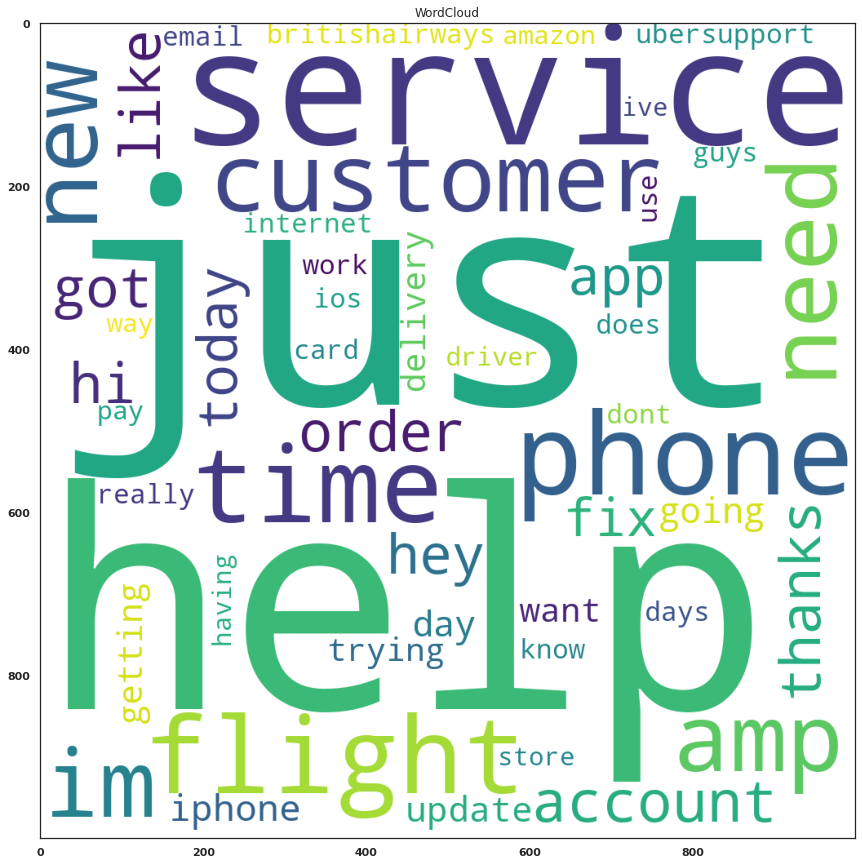

In [80]:
from wordcloud import WordCloud

sns.set_style('white')
plt.figure(figsize=(15,15))
wc = WordCloud(background_color="white",width=1000,height=1000, max_words=50,
               relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(d)
plt.title('WordCloud')
plt.imshow(wc)
plt.show()

## **Seq2Seq  MODEL DEVELOPMENT**

In [81]:
from nltk.tokenize import casual_tokenize
count_vec = CountVectorizer(tokenizer=casual_tokenize, max_features=MAX_VOCAB_SIZE - 3)
print("Fitting CountVectorizer on X and Y text data...")
count_vec.fit(tqdm(QnR["text_x"] + QnR["text_y"]))
analyzer = count_vec.build_analyzer()
vocab = {k: v + 3 for k, v in count_vec.vocabulary_.items()}
vocab['__unk__'] = UNK
vocab['__pad__'] = PAD
vocab['__start__'] = START
# Used to turn seq2seq predictions into human readable strings
reverse_vocab = {v: k for k, v in vocab.items()}
print(f"Learned vocab of {len(vocab)} items.")

Fitting CountVectorizer on X and Y text data...


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"



Learned vocab of 8192 items.


In [82]:
def to_word_idx(sentence):
    full_length = [vocab.get(tok, UNK) for tok in analyzer(sentence)] + [PAD] * MAX_MESSAGE_LEN
    return full_length[:MAX_MESSAGE_LEN]

def from_word_idx(word_idxs):
    return ' '.join(reverse_vocab[idx] for idx in word_idxs if idx != PAD).strip()

In [83]:
# Make sure our helpers work as expected...
QnR["text_x"].head().apply(to_word_idx).apply(from_word_idx)

0            @sprintcare is the worst customer service
1            @sprintcare is the worst customer service
2            @sprintcare is the worst customer service
3    y ’ all lie about your “ great ” connection . ...
4    whenever i contact customer support , they tel...
Name: text_x, dtype: object

In [84]:
print("Calculating word indexes for X...")
x = pd.np.vstack(QnR["text_x"].progress_apply(to_word_idx).values)
print("Calculating word indexes for Y...")
y = pd.np.vstack(QnR["text_y"].progress_apply(to_word_idx).values)

Calculating word indexes for X...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  



Calculating word indexes for Y...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.


In [86]:
import random
all_idx = list(range(len(x)))
train_idx = set(random.sample(all_idx, int(0.8 * len(all_idx))))
test_idx = {idx for idx in all_idx if idx not in train_idx}

train_x = x[list(train_idx)]
test_x = x[list(test_idx)]
train_y = y[list(train_idx)]
test_y = y[list(test_idx)]

assert train_x.shape == train_y.shape
assert test_x.shape == test_y.shape

print(f'Training data of shape {train_x.shape} and test data of shape {test_x.shape}.')

Training data of shape (635439, 30) and test data of shape (158860, 30).


In [87]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense, Input, LSTM, Dropout, Embedding, RepeatVector, concatenate, TimeDistributed
from keras.utils import np_utils

Using TensorFlow backend.


In [88]:
def create_model():
    shared_embedding = Embedding(
        output_dim=EMBEDDING_SIZE,
        input_dim=MAX_VOCAB_SIZE,
        input_length=MAX_MESSAGE_LEN,
        name='embedding',
    )
    
    # ENCODER
    
    encoder_input = Input(
        shape=(MAX_MESSAGE_LEN,),
        dtype='int32',
        name='encoder_input',
    )
    
    embedded_input = shared_embedding(encoder_input)
    
    # No return_sequences - since the encoder here only produces a single value for the
    # input sequence provided.
    encoder_rnn = LSTM(
        CONTEXT_SIZE,
        name='encoder',
        dropout=DROPOUT
    )
    
    context = RepeatVector(MAX_MESSAGE_LEN)(encoder_rnn(embedded_input))
    
    # DECODER
    
    last_word_input = Input(
        shape=(MAX_MESSAGE_LEN, ),
        dtype='int32',
        name='last_word_input',
    )
    
    embedded_last_word = shared_embedding(last_word_input)
    # Combines the context produced by the encoder and the last word uttered as inputs
    # to the decoder.
    decoder_input = concatenate([embedded_last_word, context], axis=2)
    
    # return_sequences causes LSTM to produce one output per timestep instead of one at the
    # end of the intput, which is important for sequence producing models.
    decoder_rnn = LSTM(
        CONTEXT_SIZE,
        name='decoder',
        return_sequences=True,
        dropout=DROPOUT
    )
    
    decoder_output = decoder_rnn(decoder_input)
    
    # TimeDistributed allows the dense layer to be applied to each decoder output per timestep
    next_word_dense = TimeDistributed(
        Dense(int(MAX_VOCAB_SIZE / 2), activation='relu'),
        name='next_word_dense',
    )(decoder_output)
    
    next_word = TimeDistributed(
        Dense(MAX_VOCAB_SIZE, activation='softmax'),
        name='next_word_softmax'
    )(next_word_dense)
    
    return Model(inputs=[encoder_input, last_word_input], outputs=[next_word])

s2s_model = create_model()
optimizer = Adam(lr=LEARNING_RATE, clipvalue=5.0)
s2s_model.compile(optimizer='adam', loss='categorical_crossentropy')

In [89]:
def add_start_token(y_array):
    """ Adds the start token to vectors.  Used for training data. """
    return np.hstack([
        START * np.ones((len(y_array), 1)),
        y_array[:, :-1],
    ])

def binarize_labels(labels):
    """ Helper function that turns integer word indexes into sparse binary matrices for 
        the expected model output.
    """
    return np.array([np_utils.to_categorical(row, num_classes=MAX_VOCAB_SIZE)
                     for row in labels])

In [90]:
def respond_to(model, text):
    """ Helper function that takes a text input and provides a text output. """
    input_y = add_start_token(PAD * np.ones((1, MAX_MESSAGE_LEN)))
    idxs = np.array(to_word_idx(text)).reshape((1, MAX_MESSAGE_LEN))
    for position in range(MAX_MESSAGE_LEN - 1):
        prediction = model.predict([idxs, input_y]).argmax(axis=2)[0]
        input_y[:,position + 1] = prediction[position]
    return from_word_idx(model.predict([idxs, input_y]).argmax(axis=2)[0])

In [91]:
def train_mini_epoch(model, start_idx, end_idx):
    """ Batching seems necessary in Kaggle Jupyter Notebook environments, since
        `model.fit` seems to freeze on larger batches (somewhere 1k-10k).
    """
    b_train_y = binarize_labels(train_y[start_idx:end_idx])
    input_train_y = add_start_token(train_y[start_idx:end_idx])
    
    model.fit(
        [train_x[start_idx:end_idx], input_train_y], 
        b_train_y,
        epochs=1,
        batch_size=BATCH_SIZE,
    )
    
    rand_idx = random.sample(list(range(len(test_x))), SUB_BATCH_SIZE)
    print('Test results:', model.evaluate(
        [test_x[rand_idx], add_start_token(test_y[rand_idx])],
        binarize_labels(test_y[rand_idx])
    ))
    
    input_strings = [
        "@AppleSupport I fix I this I stupid I problem I",
        "@AmazonHelp I hadnt expected that such a big brand like amazon would have such a poor customer service.",
    ]
    
    for input_string in input_strings:
        output_string = respond_to(model, input_string)
        print(f'> "{input_string}"\n< "{output_string}"')

In [ ]:
import time
training_time_limit = 360 * 60  # seconds (notebooks terminate after 1 hour)
start_time = time.time()
stop_after = start_time + training_time_limit

class TimesUpInterrupt(Exception):
    pass

try:
    for epoch in range(100):
        print(f'Training in epoch {epoch}...')
        for start_idx in range(0, len(train_x), SUB_BATCH_SIZE):
            train_mini_epoch(s2s_model, start_idx, start_idx + SUB_BATCH_SIZE)
            if time.time() > stop_after:
                raise TimesUpInterrupt
except KeyboardInterrupt:
    print("Halting training from keyboard interrupt.")
except TimesUpInterrupt:
    print(f"Halting after {time.time() - start_time} seconds spent training.")

In [ ]:
respond_to(s2s_model, '''@AppleSupport iPhone 8 touchID doesnt unlock while charging on 
    110v w/ 61w laptop charger to usbc lightning cable just uh.. so you guys know''')

In [ ]:
respond_to(s2s_model, '''@sprintcare I can't make calls... wtf''')